<a href="https://colab.research.google.com/github/Geunju-hub/2022-Samsung-AI-Challenge-3D-Metrology-/blob/main/Dacon_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 필요 라이브러리 불러오기
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [4]:
from google.colab.patches import cv2_imshow

In [5]:
import os

In [6]:
!ls

drive  sample_data  sample_submission.zip  simulation_data  test  train


In [7]:
# 디렉토리 바꿔주기 -> google drive 안에서 알집 풀기 위함.
!cd /content/drive/MyDrive/Dacon

In [8]:
!ls

drive  sample_data  sample_submission.zip  simulation_data  test  train


In [9]:
!unzip -qq /content/drive/MyDrive/Dacon/open.zip

replace sample_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [10]:
# 서브폴더별로 맨 앞에 있는 이미지파일 Train_Data로 옮기기
root_dir = './train/SEM'
Train_List = []
Train_Data = []
for (root, dirs, files) in os.walk(root_dir):
  count = 0
  for name in files:
    count +=1
    Train_List.append(os.path.join(root, name))
    img = cv2.imread(os.path.join(root,name))
    Train_Data.append(img)
    if(count==1):
      break;

In [11]:
# 중복 확인을 위해 set 설정 후 갯수 측정
len(set(Train_List))

2060

In [12]:
# 숫자 이상한 경우 찾아서 빼주기
for List in Train_List:
  if List.find('.ipynb') != -1:
    idx = Train_List.index(List)
    print(idx)
    print(List)
    Train_List.remove(List)
    Train_Data.pop(idx)

1096
./train/SEM/Depth_140/site_00000/.ipynb_checkpoints/SEM_000165-checkpoint.png


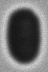

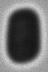

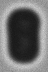

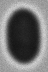

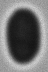

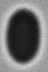

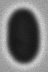

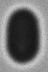

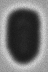

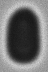

In [13]:
#이미지 잘 나오나 확인해보기
for i in range(10):
  cv2_imshow(Train_Data[i])

In [14]:
# 학습을 위해 numpy배열로 변환
X_train = np.array(Train_Data)

In [15]:
# 학습 전 shape 확인
X_train.shape

(2059, 72, 48, 3)

In [16]:
# categorical로 판별하기 위해 숫자 바꿔주기
labeldict = {0:110, 1:120, 2:130, 3:140}
reversedict = {110:0, 120:1, 130:2, 140:3}
y_train = pd.read_csv("./train/average_depth.csv")
y_train = y_train.sort_values(by="0",ascending = True)
y_train["target"] = 0
for i in range(len(y_train)):
  temp = y_train["0"][i][6:9]
  temp = int(temp)
  y_train["target"][i] = reversedict[temp]

y_train["target"].astype("str")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


1252    0
1131    0
1063    0
1293    0
1135    0
       ..
418     3
445     3
475     3
58      3
235     3
Name: target, Length: 2059, dtype: object

In [17]:
# 간단한 모델 구현
model = Sequential()
model.add(Conv2D(32,3, padding = 'same',input_shape = (72,48,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(4,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 24, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 4)                 110596    
                                                                 
Total params: 111,492
Trainable params: 111,492
Non-trainable params: 0
_________________________________________________________________


In [18]:
# loss, optimizer, metrics 정함
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
Y_train = y_train["target"].values

In [20]:
print(Y_train)

[0 0 0 ... 3 3 3]


In [21]:
# one-hot encoding 후 확인해보기
y_train= tf.keras.utils.to_categorical(Y_train,num_classes = 4)
print(y_train.shape)

(2059, 4)


In [23]:
# model 학습시키기
hist = model.fit(X_train,y_train, epochs = 10,validation_split = 0.2)

Epoch 1/10
52/52 [==============================] - 7s 126ms/step - loss: 2.4946 - accuracy: 0.7790 - val_loss: 17.0729 - val_accuracy: 0.0000e+00
Epoch 2/10
52/52 [==============================] - 6s 108ms/step - loss: 2.1885 - accuracy: 0.7753 - val_loss: 5.9736 - val_accuracy: 0.1359
Epoch 3/10
52/52 [==============================] - 5s 97ms/step - loss: 2.1232 - accuracy: 0.8069 - val_loss: 0.3556 - val_accuracy: 0.9029
Epoch 4/10
52/52 [==============================] - 6s 118ms/step - loss: 2.4526 - accuracy: 0.7602 - val_loss: 0.1032 - val_accuracy: 0.9830
Epoch 5/10
52/52 [==============================] - 5s 90ms/step - loss: 2.6147 - accuracy: 0.7608 - val_loss: 11.9150 - val_accuracy: 0.0024
Epoch 6/10
52/52 [==============================] - 5s 87ms/step - loss: 1.5374 - accuracy: 0.8136 - val_loss: 42.9436 - val_accuracy: 0.0000e+00
Epoch 7/10
52/52 [==============================] - 4s 86ms/step - loss: 2.2257 - accuracy: 0.8142 - val_loss: 5.7254 - val_accuracy: 0.0995